<a href="https://colab.research.google.com/github/AdrianCPC/Robot_trading_DS/blob/main/Robot_Trading_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 .Configuración del ambiente

In [1]:
#Determinacion de versiones disponibles para trabajar en el notebook
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


##Importacion de bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time

##Variables Globales

In [3]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

#2. Obtención de datos

In [7]:

#Extracción de datos historicos de precios del bitcoin en dolares BTC-USD(7 días - intervaloes de 5 minnutos)
def importar_base_bitcoin():
  global df_bitcoin

  symbol = "BTC-USD"
  date_start = pd.Timestamp.now() - pd.DateOffset(days=7)
  date_end = pd.Timestamp.now()


  df_bitcoin = yf.download(symbol, start=date_start, end=date_end, interval="5m")


In [8]:
importar_base_bitcoin()

[*********************100%%**********************]  1 of 1 completed


In [9]:
df_bitcoin.head(-1)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-08-19 21:55:00+00:00,26080.675781,26083.371094,26079.958984,26079.958984,26079.958984,0
2023-08-19 22:00:00+00:00,26078.091797,26078.091797,26057.126953,26057.126953,26057.126953,0
2023-08-19 22:05:00+00:00,26058.769531,26062.166016,26051.636719,26062.166016,26062.166016,0
2023-08-19 22:10:00+00:00,26073.589844,26076.486328,26073.589844,26076.486328,26076.486328,0
2023-08-19 22:15:00+00:00,26077.992188,26080.001953,26077.767578,26080.001953,26080.001953,0
...,...,...,...,...,...,...
2023-08-26 21:25:00+00:00,26029.724609,26035.916016,26029.205078,26035.916016,26035.916016,1966080
2023-08-26 21:30:00+00:00,26036.093750,26038.416016,26033.607422,26038.416016,26038.416016,1910784
2023-08-26 21:35:00+00:00,26038.228516,26038.228516,26027.451172,26028.099609,26028.099609,229888


In [10]:
#Extraccion del precio actual del BTC y variacion del precio en la ultima hora usando Web Scraping
def extraer_tendencias():
  global precio_actual, tendencia

  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 OPR/100.0.0.0'}
  url = "https://coinmarketcap.com/"
  page = requests.get(url,headers=headers)
  soup = BeautifulSoup(page.content, features="lxml")


  #Busqueda precio actual BTC en tabla
  actual_price_table = soup.find('table', class_="sc-dba2d818-3 iWUxTT cmc-table")
  btc_row = actual_price_table.find_all('tr')[1]
  all_columns = btc_row.find_all('td')
  precio_actual = float(all_columns[3].get_text().replace("$", "").replace(",", ""))

  #print("Precio Actual del Bitcoin: $", precio_actual)

  #Variación de precio en la ultima hora
  price_1h = float(all_columns[6].get_text().replace("%", ""))

  #Tendencia
  tendencia = 'baja' if price_1h < 0 else 'alta'

  print("Precio Actual del Bitcoin:", precio_actual)
  print("Variación en la última hora:", price_1h, "%")
  print("Tendencia:", tendencia)

  return precio_actual, price_1h, tendencia




In [11]:
extraer_tendencias()

Precio Actual del Bitcoin: 26029.87
Variación en la última hora: 0.19 %
Tendencia: alta


(26029.87, 0.19, 'alta')

#3. Limpieza de datos

In [12]:
def limpieza_datos():
  global df_bitcoin_limpio, media_bitcoin

  df_bitcoin_limpio = df_bitcoin.copy()

  #Elimacion duplicados en el indice
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
  #Identificacion valores nulos en la columna close
  df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)
  #Verificacion de registros de volumen menos o igual cero
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  #Observando outliers con boxplot, y filtro de Q1 y Q3
  q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= lower_bound) & (df_bitcoin_limpio['Close'] <= upper_bound)]
  df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= q1) & (df_bitcoin_limpio['Close'] <= q3)]

  #Calculo de la media_bitcoin
  media_bitcoin = df_bitcoin_limpio['Close'].mean().round(2)
  print("Media del precio del Bitcoin:", media_bitcoin)


In [13]:
limpieza_datos()

Media del precio del Bitcoin: 26062.96


In [14]:
null_value = df_bitcoin_limpio.isnull().sum()
print("Valores nulos por columna:")
print(null_value)

Valores nulos por columna:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [15]:
duplicate_total = df_bitcoin_limpio.duplicated().sum()
print("Total de registros duplicados:", duplicate_total)

Total de registros duplicados: 0


#4. Tomar decisiones

In [16]:
def tomar_decisiones():
  global algoritmo_decision

  if precio_actual >= media_bitcoin and tendencia == 'baja':
      algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
      algoritmo_decision = 'Comprar'
  else:
      algoritmo_decision = ''



In [17]:
tomar_decisiones()

In [18]:
print("Decisión del algoritmo:", algoritmo_decision)

Decisión del algoritmo: Comprar


#5. Visualización

In [35]:
def visualizacion():
  global df_bitcoin


  #Agregando columna promedio
  df_bitcoin['Promedio'] = media_bitcoin


  #Dibujando el grafico
  plt.style.use('ggplot')
  plt.rcParams['axes.grid'] = True
  plt.figure(figsize=(16, 5))
  plt.title("Precio BTC")
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio del Bitcoin', color='blue')
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Precio Promedio', linestyle='--', color='orange')

  plt.text(df_bitcoin.index[-1], media_bitcoin + 30, f'Promedio: {media_bitcoin:.2f}', color='green', verticalalignment='bottom', horizontalalignment='right')

  #tomador de decisiones en grafico
  if algoritmo_decision == 'Vender':
    plt.annotate('Vender', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-20, 30),
                  textcoords='offset points', arrowprops=dict(arrowstyle="->", color='red'))
  elif algoritmo_decision == 'Comprar':
    plt.annotate('Comprar', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-20, -30),
                  textcoords='offset points', arrowprops=dict(arrowstyle="->", color='green'))


  plt.xlabel('Fecha')
  plt.ylabel('Precio')
  plt.legend()

  plt.show()


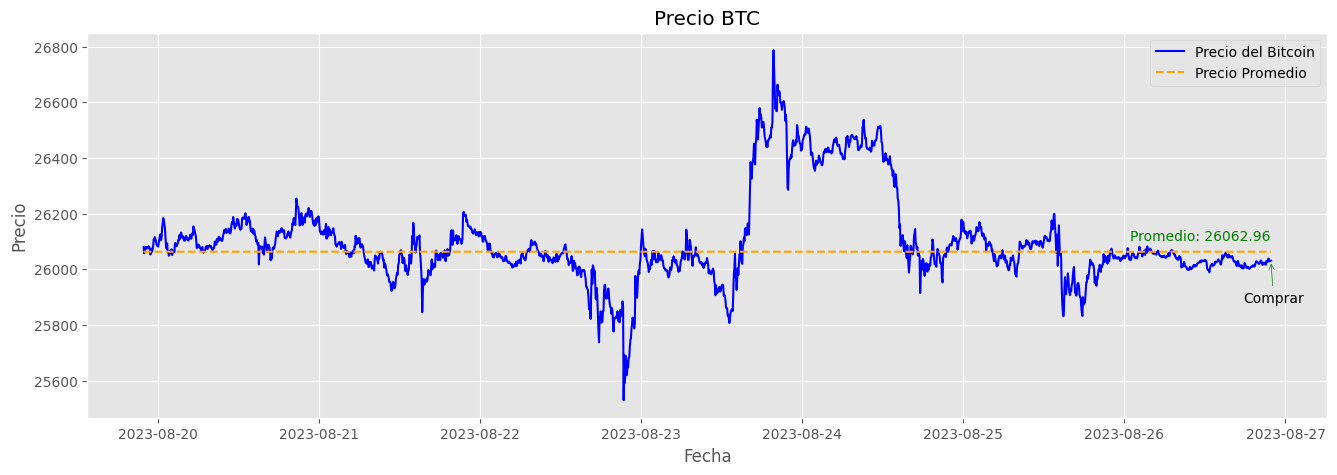

In [36]:
visualizacion()

#6. Automatización

[*********************100%%**********************]  1 of 1 completed
Precio Actual del Bitcoin: 26007.79
Variación en la última hora: 0.41 %
Tendencia: alta
Media del precio del Bitcoin: 26062.72


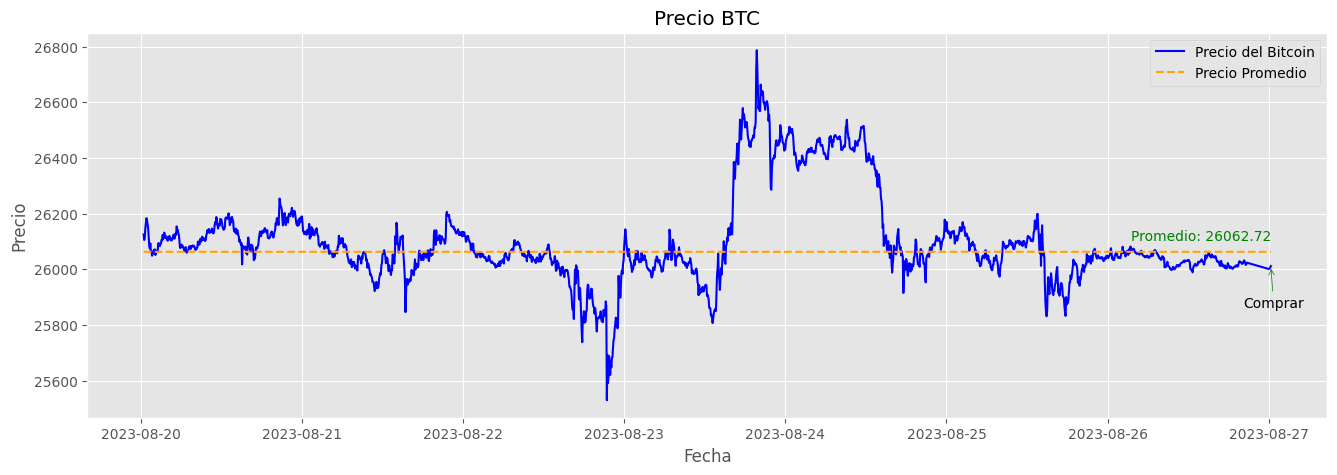

KeyboardInterrupt: ignored

In [39]:
from IPython.display import clear_output
import time


while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)

